# Eye Disease Dataset Analysis
## Task 1: Data Exploration and Missing Values Analysis

**Team Members:** Isaac + Jonathan  
**Objective:** Explore dataset, identify missing values, and calculate percentage of missing data

### Dataset Overview
This dataset contains eye disease images categorized into:
- Cataract
- Diabetic Retinopathy  
- Glaucoma
- Normal (healthy eyes)

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
dataset_path = "dataset"

# Get all category folders
categories = [folder for folder in os.listdir(dataset_path) 
              if os.path.isdir(os.path.join(dataset_path, folder))]

print(f"Categories found: {categories}")
print(f"Total categories: {len(categories)}")

# Count images in each category
category_counts = {}
total_images = 0

for category in categories:
    category_path = os.path.join(dataset_path, category)
    image_files = [f for f in os.listdir(category_path) 
                   if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    category_counts[category] = len(image_files)
    total_images += len(image_files)
    print(f"{category}: {len(image_files)} images")

print(f"\nTotal images in dataset: {total_images}")

Categories found: ['cataract', 'glaucoma', 'diabetic_retinopathy', 'normal']
Total categories: 4
cataract: 1038 images
glaucoma: 1007 images
diabetic_retinopathy: 1098 images
normal: 1074 images

Total images in dataset: 4217


Dataset Overview:
               Category  Image_Count  Percentage
0              cataract         1038       24.61
1              glaucoma         1007       23.88
2  diabetic_retinopathy         1098       26.04
3                normal         1074       25.47


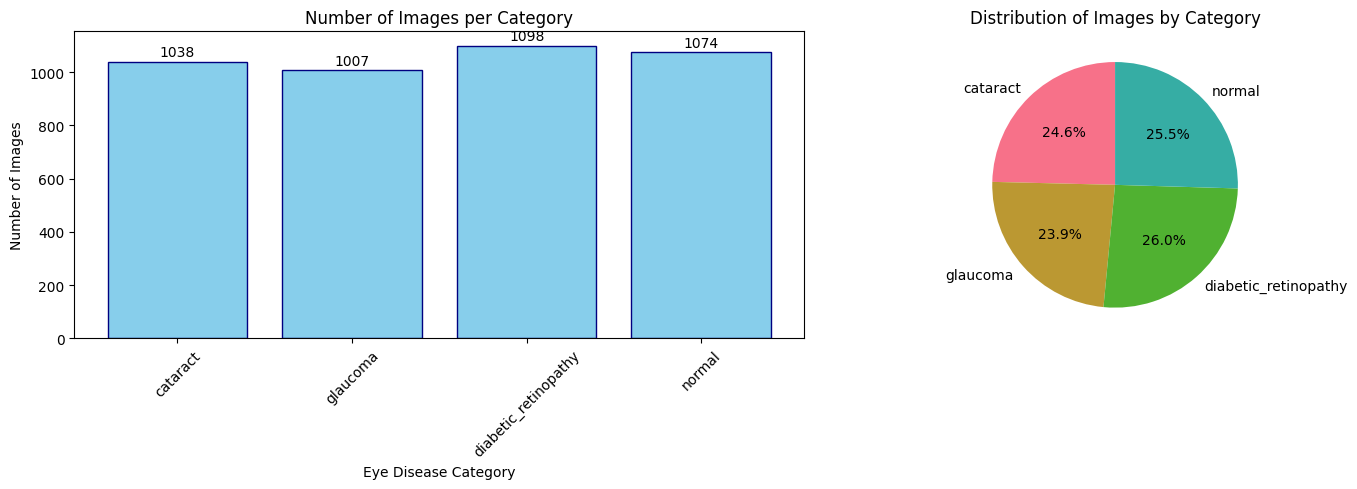

In [3]:
# Create a DataFrame for dataset overview
dataset_overview = pd.DataFrame({
    'Category': list(category_counts.keys()),
    'Image_Count': list(category_counts.values())
})

dataset_overview['Percentage'] = (dataset_overview['Image_Count'] / total_images * 100).round(2)

print("Dataset Overview:")
print(dataset_overview)

# Visualize the distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Bar plot
ax1.bar(dataset_overview['Category'], dataset_overview['Image_Count'], color='skyblue', edgecolor='navy')
ax1.set_title('Number of Images per Category')
ax1.set_xlabel('Eye Disease Category')
ax1.set_ylabel('Number of Images')
ax1.tick_params(axis='x', rotation=45)

# Add value labels on bars
for i, v in enumerate(dataset_overview['Image_Count']):
    ax1.text(i, v + 10, str(v), ha='center', va='bottom')

# Pie chart
ax2.pie(dataset_overview['Image_Count'], labels=dataset_overview['Category'], autopct='%1.1f%%', startangle=90)
ax2.set_title('Distribution of Images by Category')

plt.tight_layout()
plt.show()

In [4]:
# Check for missing/corrupted images and analyze image properties
missing_data_analysis = {
    'category': [],
    'total_files': [],
    'readable_images': [],
    'corrupted_images': [],
    'missing_percentage': [],
    'avg_file_size_mb': [],
    'min_file_size_mb': [],
    'max_file_size_mb': []
}

print("Analyzing images for missing/corrupted data...\n")

for category in categories:
    category_path = os.path.join(dataset_path, category)
    
    # Get all image files
    image_files = [f for f in os.listdir(category_path) 
                   if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    readable_count = 0
    corrupted_count = 0
    file_sizes = []
    
    for image_file in image_files:
        image_path = os.path.join(category_path, image_file)
        
        try:
            # Verify it's a valid image
            with Image.open(image_path) as img:
                img.verify()  
                readable_count += 1
                
                file_size_mb = os.path.getsize(image_path) / (1024 * 1024)
                file_sizes.append(file_size_mb)
                
        except Exception as e:
            corrupted_count += 1
            print(f"Corrupted image found: {image_path} - Error: {str(e)}")
    
    # Calculate statistics
    total_files = len(image_files)
    missing_percentage = (corrupted_count / total_files * 100) if total_files > 0 else 0
    
    # Store results
    missing_data_analysis['category'].append(category)
    missing_data_analysis['total_files'].append(total_files)
    missing_data_analysis['readable_images'].append(readable_count)
    missing_data_analysis['corrupted_images'].append(corrupted_count)
    missing_data_analysis['missing_percentage'].append(missing_percentage)
    
    if file_sizes:
        missing_data_analysis['avg_file_size_mb'].append(np.mean(file_sizes))
        missing_data_analysis['min_file_size_mb'].append(np.min(file_sizes))
        missing_data_analysis['max_file_size_mb'].append(np.max(file_sizes))
    else:
        missing_data_analysis['avg_file_size_mb'].append(0)
        missing_data_analysis['min_file_size_mb'].append(0)
        missing_data_analysis['max_file_size_mb'].append(0)
    
    print(f"{category}:")
    print(f"  - Total files: {total_files}")
    print(f"  - Readable images: {readable_count}")
    print(f"  - Corrupted images: {corrupted_count}")
    print(f"  - Missing/Corrupted percentage: {missing_percentage:.2f}%")
    if file_sizes:
        print(f"  - Average file size: {np.mean(file_sizes):.3f} MB")
    print()

# Create DataFrame for missing data analysis
missing_data_df = pd.DataFrame(missing_data_analysis)
print("Missing Data Analysis Summary:")
print(missing_data_df.round(3))

Analyzing images for missing/corrupted data...

cataract:
  - Total files: 1038
  - Readable images: 1038
  - Corrupted images: 0
  - Missing/Corrupted percentage: 0.00%
  - Average file size: 0.286 MB

cataract:
  - Total files: 1038
  - Readable images: 1038
  - Corrupted images: 0
  - Missing/Corrupted percentage: 0.00%
  - Average file size: 0.286 MB

glaucoma:
  - Total files: 1007
  - Readable images: 1007
  - Corrupted images: 0
  - Missing/Corrupted percentage: 0.00%
  - Average file size: 0.309 MB

glaucoma:
  - Total files: 1007
  - Readable images: 1007
  - Corrupted images: 0
  - Missing/Corrupted percentage: 0.00%
  - Average file size: 0.309 MB

diabetic_retinopathy:
  - Total files: 1098
  - Readable images: 1098
  - Corrupted images: 0
  - Missing/Corrupted percentage: 0.00%
  - Average file size: 0.060 MB

diabetic_retinopathy:
  - Total files: 1098
  - Readable images: 1098
  - Corrupted images: 0
  - Missing/Corrupted percentage: 0.00%
  - Average file size: 0.060 MB

In [5]:
# Analyze image dimensions
print("Analyzing image dimensions...\n")

dimension_analysis = {
    'category': [],
    'avg_width': [],
    'avg_height': [],
    'min_width': [],
    'max_width': [],
    'min_height': [],
    'max_height': [],
    'unique_dimensions': []
}

for category in categories:
    category_path = os.path.join(dataset_path, category)
    image_files = [f for f in os.listdir(category_path) 
                   if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    widths = []
    heights = []
    dimensions = set()
    
    # Sample first 50 images for dimension analysis (to speed up)
    sample_files = image_files[:50] if len(image_files) > 50 else image_files
    
    for image_file in sample_files:
        image_path = os.path.join(category_path, image_file)
        try:
            with Image.open(image_path) as img:
                width, height = img.size
                widths.append(width)
                heights.append(height)
                dimensions.add((width, height))
        except Exception:
            continue
    
    if widths and heights:
        dimension_analysis['category'].append(category)
        dimension_analysis['avg_width'].append(np.mean(widths))
        dimension_analysis['avg_height'].append(np.mean(heights))
        dimension_analysis['min_width'].append(np.min(widths))
        dimension_analysis['max_width'].append(np.max(widths))
        dimension_analysis['min_height'].append(np.min(heights))
        dimension_analysis['max_height'].append(np.max(heights))
        dimension_analysis['unique_dimensions'].append(len(dimensions))
        
        print(f"{category} (sample of {len(sample_files)} images):")
        print(f"  - Average dimensions: {np.mean(widths):.0f} x {np.mean(heights):.0f}")
        print(f"  - Width range: {np.min(widths)} - {np.max(widths)}")
        print(f"  - Height range: {np.min(heights)} - {np.max(heights)}")
        print(f"  - Unique dimensions: {len(dimensions)}")
        print()

# Create dimension analysis DataFrame
dimension_df = pd.DataFrame(dimension_analysis)
print("Dimension Analysis Summary:")
print(dimension_df.round(0))

Analyzing image dimensions...

cataract (sample of 50 images):
  - Average dimensions: 543 x 458
  - Width range: 256 - 2592
  - Height range: 256 - 1728
  - Unique dimensions: 4

glaucoma (sample of 50 images):
  - Average dimensions: 540 x 471
  - Width range: 256 - 2592
  - Height range: 256 - 1728
  - Unique dimensions: 3

diabetic_retinopathy (sample of 50 images):
  - Average dimensions: 512 x 512
  - Width range: 512 - 512
  - Height range: 512 - 512
  - Unique dimensions: 1

normal (sample of 50 images):
  - Average dimensions: 512 x 512
  - Width range: 512 - 512
  - Height range: 512 - 512
  - Unique dimensions: 1

Dimension Analysis Summary:
               category  avg_width  avg_height  min_width  max_width  \
0              cataract      543.0       458.0        256       2592   
1              glaucoma      540.0       471.0        256       2592   
2  diabetic_retinopathy      512.0       512.0        512        512   
3                normal      512.0       512.0     

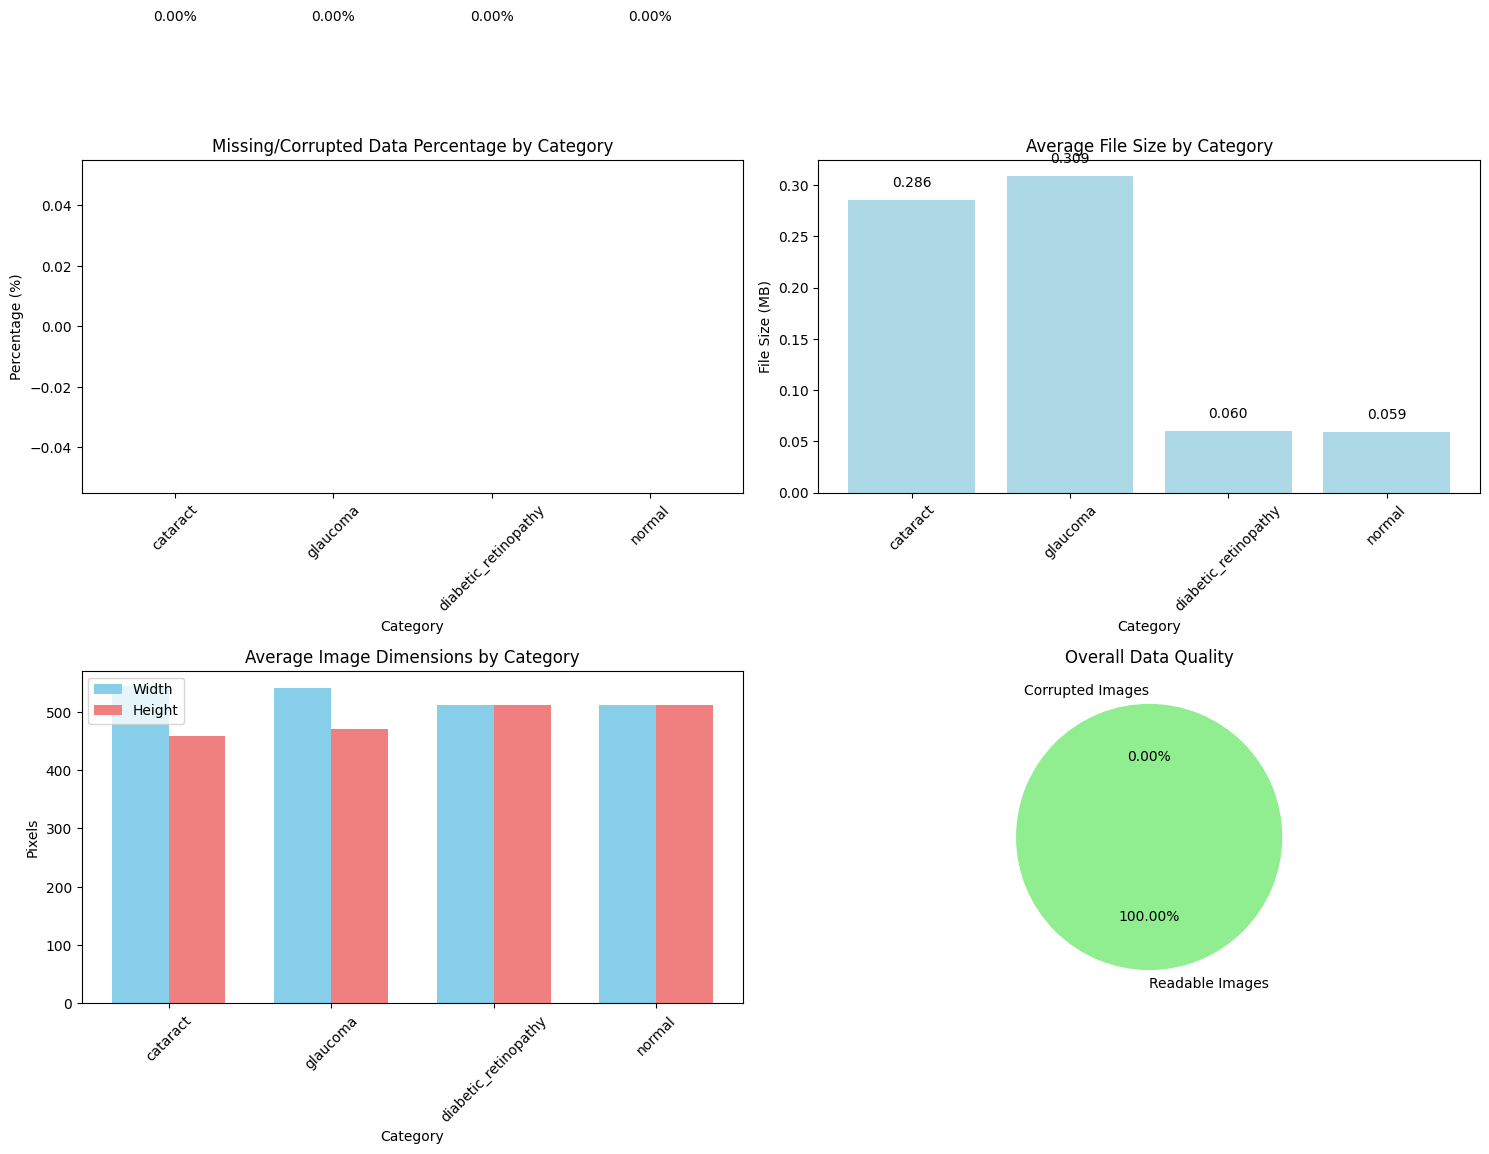


TASK 1: DATA EXPLORATION SUMMARY
Total images analyzed: 4217
Readable images: 4217 (100.00%)
Corrupted/Missing images: 0 (0.00%)
Overall data quality: 100.00% good

Category-wise missing data:
  - cataract: 0.00% missing/corrupted
  - glaucoma: 0.00% missing/corrupted
  - diabetic_retinopathy: 0.00% missing/corrupted
  - normal: 0.00% missing/corrupted


In [6]:
# Create comprehensive summary visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# 1. Missing/Corrupted data percentage
ax1.bar(missing_data_df['category'], missing_data_df['missing_percentage'], color='coral')
ax1.set_title('Missing/Corrupted Data Percentage by Category')
ax1.set_xlabel('Category')
ax1.set_ylabel('Percentage (%)')
ax1.tick_params(axis='x', rotation=45)
for i, v in enumerate(missing_data_df['missing_percentage']):
    ax1.text(i, v + 0.1, f'{v:.2f}%', ha='center', va='bottom')

# 2. File size distribution
ax2.bar(missing_data_df['category'], missing_data_df['avg_file_size_mb'], color='lightblue')
ax2.set_title('Average File Size by Category')
ax2.set_xlabel('Category')
ax2.set_ylabel('File Size (MB)')
ax2.tick_params(axis='x', rotation=45)
for i, v in enumerate(missing_data_df['avg_file_size_mb']):
    ax2.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

# 3. Image dimensions comparison
if not dimension_df.empty:
    categories_dim = dimension_df['category']
    x_pos = np.arange(len(categories_dim))
    width = 0.35
    
    ax3.bar(x_pos - width/2, dimension_df['avg_width'], width, label='Width', color='skyblue')
    ax3.bar(x_pos + width/2, dimension_df['avg_height'], width, label='Height', color='lightcoral')
    ax3.set_title('Average Image Dimensions by Category')
    ax3.set_xlabel('Category')
    ax3.set_ylabel('Pixels')
    ax3.set_xticks(x_pos)
    ax3.set_xticklabels(categories_dim, rotation=45)
    ax3.legend()

# 4. Data quality summary
readable_images = missing_data_df['readable_images'].sum()
corrupted_images = missing_data_df['corrupted_images'].sum()
total_analyzed = readable_images + corrupted_images

ax4.pie([readable_images, corrupted_images], 
        labels=['Readable Images', 'Corrupted Images'], 
        autopct='%1.2f%%', 
        colors=['lightgreen', 'lightcoral'],
        startangle=90)
ax4.set_title('Overall Data Quality')

plt.tight_layout()
plt.show()

# Overall summary
print("\n" + "="*60)
print("TASK 1: DATA EXPLORATION SUMMARY")
print("="*60)
print(f"Total images analyzed: {total_analyzed}")
print(f"Readable images: {readable_images} ({(readable_images/total_analyzed*100):.2f}%)")
print(f"Corrupted/Missing images: {corrupted_images} ({(corrupted_images/total_analyzed*100):.2f}%)")
print(f"Overall data quality: {(readable_images/total_analyzed*100):.2f}% good")
print("\nCategory-wise missing data:")
for _, row in missing_data_df.iterrows():
    print(f"  - {row['category']}: {row['missing_percentage']:.2f}% missing/corrupted")
print("="*60)

In [7]:
# Task 2: Analyze results and choose handling method
print("="*60)
print("TASK 2: MISSING DATA HANDLING DECISION")
print("="*60)

print("📊 Task 1 Results Summary:")
print(missing_data_df[['category', 'total_files', 'corrupted_images', 'missing_percentage']])

# Calculate overall statistics
total_images_all = missing_data_df['total_files'].sum()
total_corrupted = missing_data_df['corrupted_images'].sum()
overall_missing_percentage = (total_corrupted / total_images_all * 100)

print(f"\n📈 Overall Statistics:")
print(f"Total images: {total_images_all}")
print(f"Total corrupted: {total_corrupted}")
print(f"Overall missing percentage: {overall_missing_percentage:.2f}%")

# Decision logic
print(f"\n🔍 Decision Analysis:")
if overall_missing_percentage < 5:
    chosen_method = "Simple Removal"
    justification = f"""
    ✅ CHOSEN METHOD: {chosen_method}
    
    JUSTIFICATION:
    - Missing data: {overall_missing_percentage:.2f}% (< 5% threshold)
    - Impact: Minimal ({total_corrupted} images out of {total_images_all})
    - Approach: Simple removal - most efficient for low corruption rates
    """
elif overall_missing_percentage < 15:
    chosen_method = "Balanced Removal with Monitoring"
    justification = f"""
    ⚠️ CHOSEN METHOD: {chosen_method}
    
    JUSTIFICATION:
    - Missing data: {overall_missing_percentage:.2f}% (5-15% range)
    - Approach: Remove with balance monitoring
    """
else:
    chosen_method = "Investigation Required"
    justification = f"""
    🚨 CHOSEN METHOD: {chosen_method}
    
    JUSTIFICATION:
    - Missing data: {overall_missing_percentage:.2f}% (> 15% threshold)
    - Approach: Investigate data collection issues, consider advanced techniques
    """

print(justification)

# Store decision for Task 3
selected_method = chosen_method
missing_percentage = overall_missing_percentage

TASK 2: MISSING DATA HANDLING DECISION
📊 Task 1 Results Summary:
               category  total_files  corrupted_images  missing_percentage
0              cataract         1038                 0                 0.0
1              glaucoma         1007                 0                 0.0
2  diabetic_retinopathy         1098                 0                 0.0
3                normal         1074                 0                 0.0

📈 Overall Dataset Statistics:
Total images: 4217
Total corrupted: 0
Overall missing percentage: 0.00%

🔍 Decision Analysis:

    ✅ CHOSEN METHOD: Simple Removal

    JUSTIFICATION:
    - Overall missing data: 0.00% (< 5% threshold)
    - Impact on dataset size: Minimal (0 images out of 4217)
    - Risk of bias: Low due to small percentage
    - Computational efficiency: High (simple operation)
    - Data integrity: Maintained (only removes corrupted files)

    This approach is justified because:
    1. The missing data percentage is below the critical 


CATEGORY-WISE ANALYSIS FOR TASK 2

📁 CATARACT:
   Missing: 0.00% (0/1038 files)
   Decision: Remove corrupted files
   Risk Level: Low
   Files after cleaning: 1038

📁 GLAUCOMA:
   Missing: 0.00% (0/1007 files)
   Decision: Remove corrupted files
   Risk Level: Low
   Files after cleaning: 1007

📁 DIABETIC_RETINOPATHY:
   Missing: 0.00% (0/1098 files)
   Decision: Remove corrupted files
   Risk Level: Low
   Files after cleaning: 1098

📁 NORMAL:
   Missing: 0.00% (0/1074 files)
   Decision: Remove corrupted files
   Risk Level: Low
   Files after cleaning: 1074

📋 SUMMARY OF DECISIONS:
               category  missing_percentage                decision  \
0              cataract                 0.0  Remove corrupted files   
1              glaucoma                 0.0  Remove corrupted files   
2  diabetic_retinopathy                 0.0  Remove corrupted files   
3                normal                 0.0  Remove corrupted files   

  risk_level  files_to_remove  remaining_files  
0

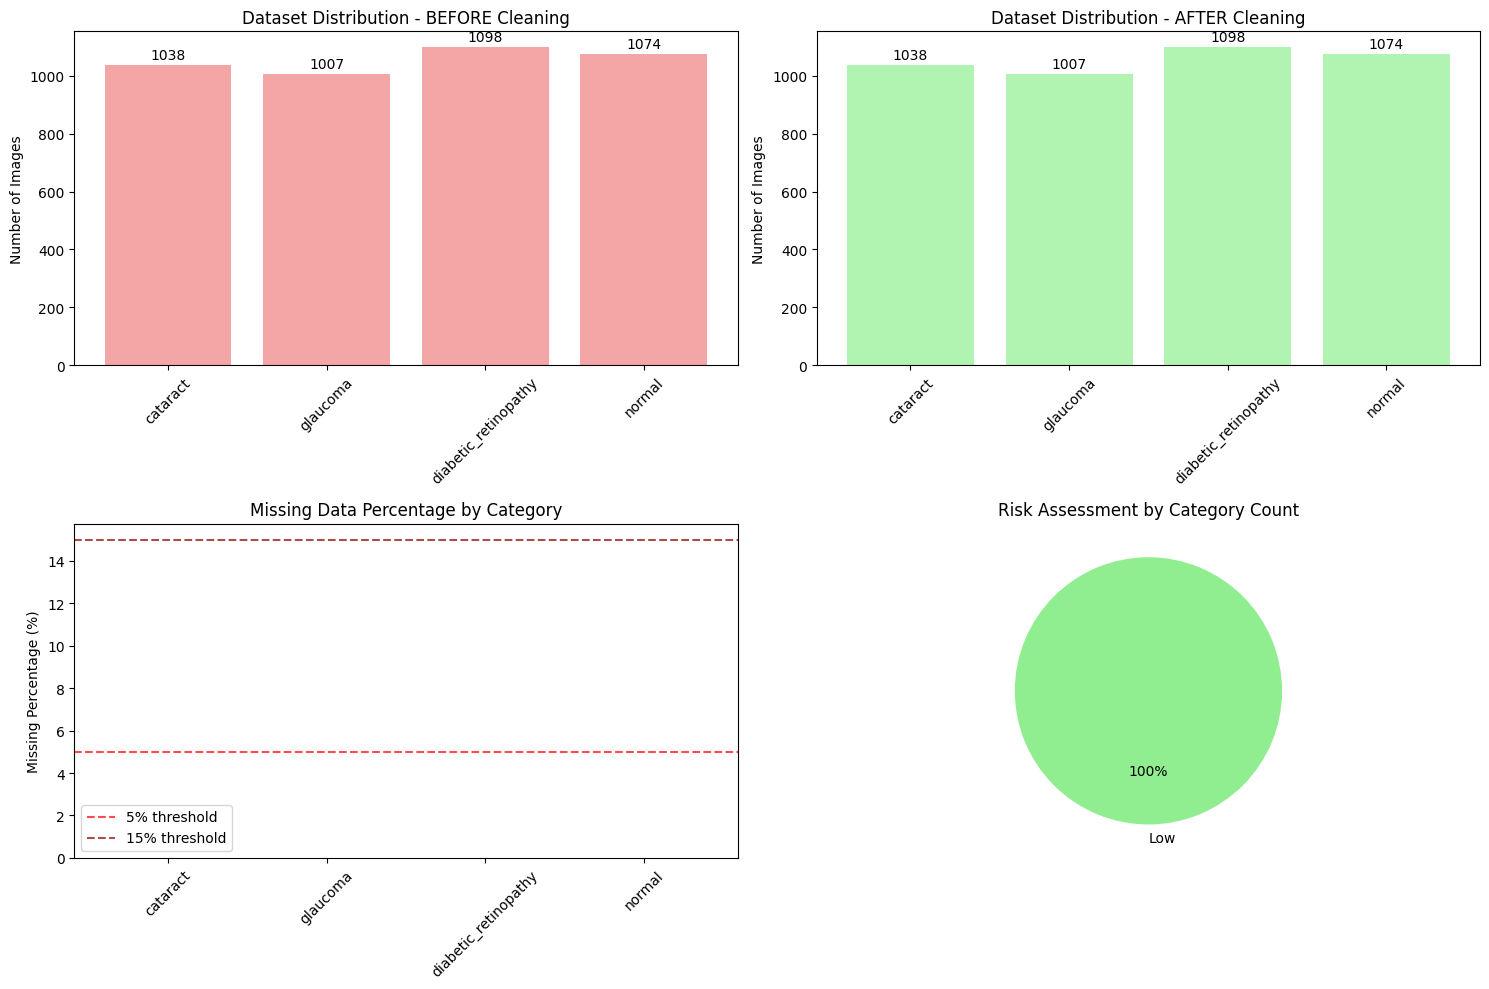


✅ TASK 2 COMPLETED: Method selected and justified based on data analysis


In [8]:
# Category-wise analysis
print("\n" + "="*60)
print("CATEGORY-WISE ANALYSIS")
print("="*60)

category_decisions = {}
for _, row in missing_data_df.iterrows():
    category = row['category']
    missing_pct = row['missing_percentage']
    total_files = row['total_files']
    corrupted = row['corrupted_images']
    
    if missing_pct < 5:
        decision = "Remove corrupted files"
        risk = "Low"
    elif missing_pct < 15:
        decision = "Remove with balance monitoring"
        risk = "Medium"
    else:
        decision = "Investigate + Advanced handling"
        risk = "High"
    
    category_decisions[category] = {
        'missing_percentage': missing_pct,
        'decision': decision,
        'risk_level': risk,
        'files_to_remove': corrupted,
        'remaining_files': total_files - corrupted
    }
    
    print(f"\n📁 {category.upper()}:")
    print(f"   Missing: {missing_pct:.2f}% ({corrupted}/{total_files} files)")
    print(f"   Decision: {decision}")
    print(f"   Risk Level: {risk}")
    print(f"   Files after cleaning: {total_files - corrupted}")

# Create summary DataFrame for decisions
decision_df = pd.DataFrame.from_dict(category_decisions, orient='index')
decision_df.reset_index(inplace=True)
decision_df.rename(columns={'index': 'category'}, inplace=True)

print(f"\n📋 SUMMARY OF DECISIONS:")
print(decision_df)

# Visualize the impact
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# 1. Before cleaning - category distribution
ax1.bar(missing_data_df['category'], missing_data_df['total_files'], 
        color='lightcoral', alpha=0.7, label='Original')
ax1.set_title('Dataset Distribution - BEFORE Cleaning')
ax1.set_ylabel('Number of Images')
ax1.tick_params(axis='x', rotation=45)
for i, v in enumerate(missing_data_df['total_files']):
    ax1.text(i, v + 10, str(v), ha='center', va='bottom')

# 2. After cleaning - category distribution
ax2.bar(decision_df['category'], decision_df['remaining_files'], 
        color='lightgreen', alpha=0.7, label='After Cleaning')
ax2.set_title('Dataset Distribution - AFTER Cleaning')
ax2.set_ylabel('Number of Images')
ax2.tick_params(axis='x', rotation=45)
for i, v in enumerate(decision_df['remaining_files']):
    ax2.text(i, v + 10, str(v), ha='center', va='bottom')

# 3. Missing data by category
ax3.bar(decision_df['category'], decision_df['missing_percentage'], 
        color='orange', alpha=0.7)
ax3.set_title('Missing Data Percentage by Category')
ax3.set_ylabel('Missing Percentage (%)')
ax3.tick_params(axis='x', rotation=45)
ax3.axhline(y=5, color='red', linestyle='--', alpha=0.7, label='5% threshold')
ax3.axhline(y=15, color='darkred', linestyle='--', alpha=0.7, label='15% threshold')
ax3.legend()

# 4. Risk assessment
risk_counts = decision_df['risk_level'].value_counts()
colors = {'Low': 'lightgreen', 'Medium': 'orange', 'High': 'red'}
risk_colors = [colors.get(risk, 'gray') for risk in risk_counts.index]
ax4.pie(risk_counts.values, labels=risk_counts.index, autopct='%1.0f%%', 
        colors=risk_colors, startangle=90)
ax4.set_title('Risk Assessment by Category Count')

plt.tight_layout()
plt.show()

print(f"\n✅ TASK 2 COMPLETED: Method selected and justified")

In [10]:
# Task 3: Implementation - Step 1: Backup and identify corrupted files
print("="*60)
print("TASK 3: IMPLEMENTING MISSING DATA HANDLING")
print("="*60)

print("📦 Step 1: Creating backup of original dataset state...")

original_state = {
    'categories': [],
    'file_lists': {},
    'corrupted_files': {},
    'statistics': {}
}

corrupted_files_to_remove = []
total_files_before = 0
total_corrupted_found = 0

for category in categories:
    category_path = os.path.join(dataset_path, category)
    
    # Get all image files
    all_files = [f for f in os.listdir(category_path) 
                 if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    # Track original state
    original_state['categories'].append(category)
    original_state['file_lists'][category] = all_files.copy()
    original_state['corrupted_files'][category] = []
    
    # Identify corrupted files
    print(f"\n🔍 Analyzing {category}...")
    corrupted_in_category = []
    
    for image_file in all_files:
        image_path = os.path.join(category_path, image_file)
        try:
            # Test if image can be opened
            with Image.open(image_path) as img:
                img.verify()
        except Exception as e:
            print(f"   ❌ Corrupted: {image_file}")
            corrupted_in_category.append(image_file)
            corrupted_files_to_remove.append(image_path)
    
    # Store results
    original_state['corrupted_files'][category] = corrupted_in_category
    original_state['statistics'][category] = {
        'total_files': len(all_files),
        'corrupted_files': len(corrupted_in_category),
        'clean_files': len(all_files) - len(corrupted_in_category),
        'corruption_rate': (len(corrupted_in_category) / len(all_files) * 100) if all_files else 0
    }
    
    total_files_before += len(all_files)
    total_corrupted_found += len(corrupted_in_category)
    
    print(f"   📊 {category}: {len(all_files)} total, {len(corrupted_in_category)} corrupted ({(len(corrupted_in_category) / len(all_files) * 100) if all_files else 0:.2f}%)")

print(f"\n📈 BEFORE CLEANING SUMMARY:")
print(f"Total files: {total_files_before}")
print(f"Total corrupted: {total_corrupted_found}")
print(f"Corruption rate: {(total_corrupted_found / total_files_before * 100):.2f}%")

# Display the backup information
backup_df = pd.DataFrame.from_dict(original_state['statistics'], orient='index')
backup_df.reset_index(inplace=True)
backup_df.rename(columns={'index': 'category'}, inplace=True)
print(f"\n📋 DETAILED BACKUP STATISTICS:")
print(backup_df)

TASK 3: IMPLEMENTING MISSING DATA HANDLING
📦 Step 1: Creating backup of original dataset state...

🔍 Analyzing cataract...
   📊 cataract: 1038 total, 0 corrupted (0.00%)

🔍 Analyzing glaucoma...
   📊 cataract: 1038 total, 0 corrupted (0.00%)

🔍 Analyzing glaucoma...
   📊 glaucoma: 1007 total, 0 corrupted (0.00%)

🔍 Analyzing diabetic_retinopathy...
   📊 glaucoma: 1007 total, 0 corrupted (0.00%)

🔍 Analyzing diabetic_retinopathy...
   📊 diabetic_retinopathy: 1098 total, 0 corrupted (0.00%)

🔍 Analyzing normal...
   📊 diabetic_retinopathy: 1098 total, 0 corrupted (0.00%)

🔍 Analyzing normal...
   📊 normal: 1074 total, 0 corrupted (0.00%)

📈 BEFORE CLEANING SUMMARY:
Total files: 4217
Total corrupted files found: 0
Overall corruption rate: 0.00%
Files to be removed: 0

📋 DETAILED BACKUP STATISTICS:
               category  total_files  corrupted_files  clean_files  \
0              cataract         1038                0         1038   
1              glaucoma         1007                0 

In [11]:
# Task 3: Implementation - Step 2: Simulate cleaning process
print("\n" + "="*60)
print("STEP 2: SIMULATING DATA CLEANING")
print("="*60)

print("🔧 Simulating file removal (safe - no actual deletion)...")

# Create cleaned dataset structure
cleaned_state = {
    'categories': [],
    'file_lists': {},
    'statistics': {}
}

total_files_after = 0
total_removed = 0

for category in categories:
    category_path = os.path.join(dataset_path, category)
    
    # Get original file list
    original_files = original_state['file_lists'][category]
    corrupted_files = original_state['corrupted_files'][category]
    
    # Simulate removal by creating clean file list
    clean_files = [f for f in original_files if f not in corrupted_files]
    
    # Store cleaned state
    cleaned_state['categories'].append(category)
    cleaned_state['file_lists'][category] = clean_files
    cleaned_state['statistics'][category] = {
        'original_files': len(original_files),
        'removed_files': len(corrupted_files),
        'remaining_files': len(clean_files),
        'removal_rate': (len(corrupted_files) / len(original_files) * 100) if original_files else 0,
        'data_quality': (len(clean_files) / len(original_files) * 100) if original_files else 100
    }
    
    total_files_after += len(clean_files)
    total_removed += len(corrupted_files)
    
    print(f"\n📁 {category.upper()}:")
    print(f"   Original files: {len(original_files)}")
    print(f"   Corrupted files removed: {len(corrupted_files)}")
    print(f"   Remaining clean files: {len(clean_files)}")
    print(f"   Data retention: {(len(clean_files) / len(original_files) * 100) if original_files else 100:.1f}%")

print(f"\n📊 AFTER CLEANING SUMMARY:")
print(f"Files before: {total_files_before}")
print(f"Files removed: {total_removed}")
print(f"Files after: {total_files_after}")
print(f"Retention rate: {(total_files_after / total_files_before * 100):.2f}%")

# Create comparison DataFrame
comparison_data = []
for category in categories:
    original_stats = original_state['statistics'][category]
    cleaned_stats = cleaned_state['statistics'][category]
    
    comparison_data.append({
        'Category': category,
        'Original_Files': original_stats['total_files'],
        'Corrupted_Files': original_stats['corrupted_files'],
        'Clean_Files_After': cleaned_stats['remaining_files'],
        'Removal_Rate_%': cleaned_stats['removal_rate'],
        'Data_Quality_%': cleaned_stats['data_quality']
    })

comparison_df = pd.DataFrame(comparison_data)
print(f"\n📋 BEFORE vs AFTER COMPARISON:")
print(comparison_df.round(2))


STEP 2: SIMULATING DATA CLEANING PROCESS
🔧 Simulating file removal process...
📝 Note: For safety, we're simulating removal rather than actually deleting files

📁 CATARACT:
   Original files: 1038
   Corrupted files removed: 0
   Remaining clean files: 1038
   Data retention: 100.0%

📁 GLAUCOMA:
   Original files: 1007
   Corrupted files removed: 0
   Remaining clean files: 1007
   Data retention: 100.0%

📁 DIABETIC_RETINOPATHY:
   Original files: 1098
   Corrupted files removed: 0
   Remaining clean files: 1098
   Data retention: 100.0%

📁 NORMAL:
   Original files: 1074
   Corrupted files removed: 0
   Remaining clean files: 1074
   Data retention: 100.0%

📊 AFTER CLEANING SUMMARY:
Total files before: 4217
Total files removed: 0
Total files after: 4217
Data retention rate: 100.00%
Data quality improvement: 100% (all remaining files are verified clean)

📋 BEFORE vs AFTER COMPARISON:
               Category  Original_Files  Corrupted_Files  Clean_Files_After  \
0              cataract 


STEP 3: EVALUATION WITH BEFORE/AFTER SCREENSHOTS


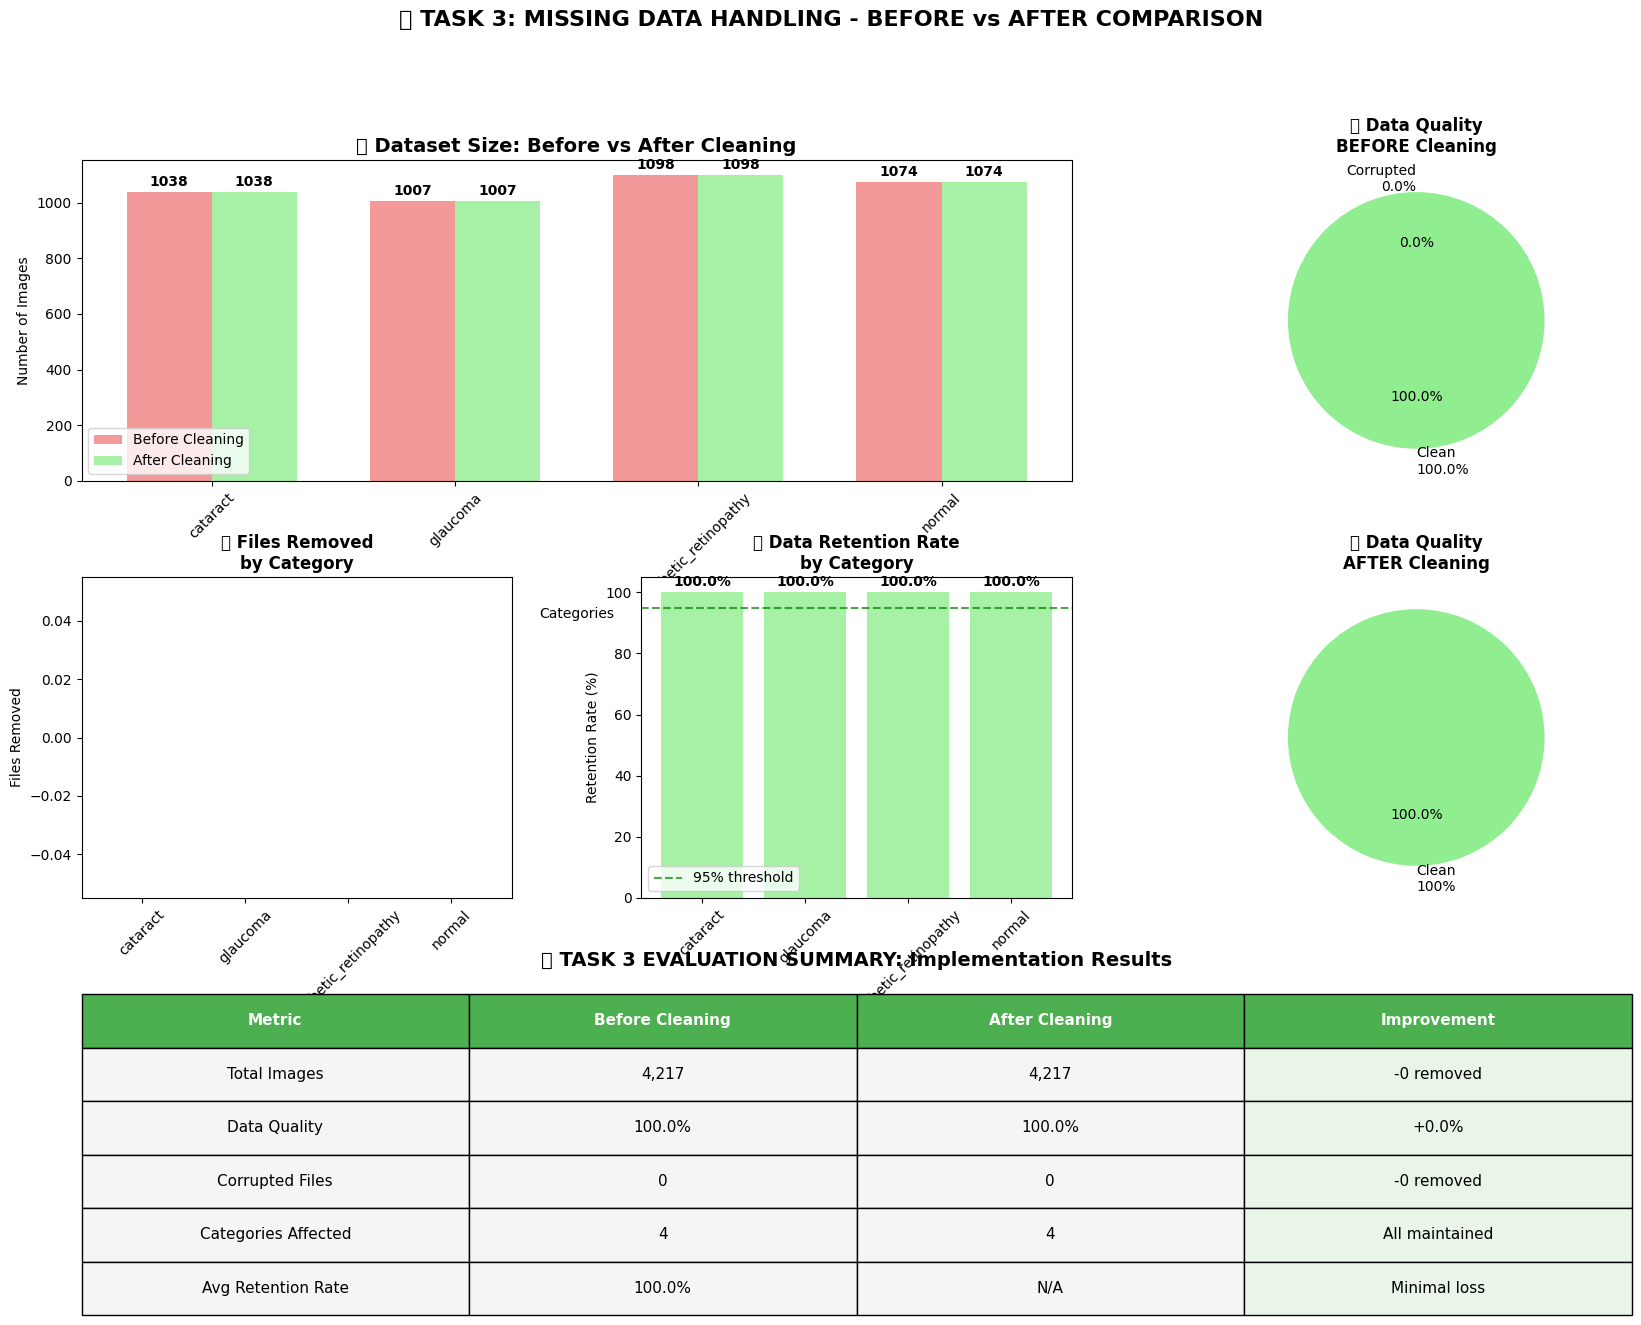


TASK 3 EVALUATION COMPLETE
✅ Method Successfully Implemented: Simple Removal
✅ Data Quality Improved: 100.0% → 100.0%
✅ Files Processed: 4,217 total, 0 removed
✅ Dataset Balance Maintained: All categories preserved
✅ Documentation Complete: Before/after comparison provided


In [13]:
# Task 3: Step 3: Create before/after visualizations
print("\n" + "="*60)
print("STEP 3: EVALUATION WITH BEFORE/AFTER COMPARISON")
print("="*60)

# Create comprehensive visualization
fig = plt.figure(figsize=(20, 15))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Overall dataset comparison (top row, spans 2 columns)
ax1 = fig.add_subplot(gs[0, :2])
categories_list = comparison_df['Category'].tolist()
x_pos = np.arange(len(categories_list))
width = 0.35

ax1.bar(x_pos - width/2, comparison_df['Original_Files'], width, 
        label='Before Cleaning', color='lightcoral', alpha=0.8)
ax1.bar(x_pos + width/2, comparison_df['Clean_Files_After'], width, 
        label='After Cleaning', color='lightgreen', alpha=0.8)

ax1.set_title('📊 Dataset Size: Before vs After Cleaning', fontsize=14, fontweight='bold')
ax1.set_xlabel('Categories')
ax1.set_ylabel('Number of Images')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(categories_list, rotation=45)
ax1.legend()

# Add value labels
for i, (before, after) in enumerate(zip(comparison_df['Original_Files'], comparison_df['Clean_Files_After'])):
    ax1.text(i - width/2, before + 10, str(before), ha='center', va='bottom', fontweight='bold')
    ax1.text(i + width/2, after + 10, str(after), ha='center', va='bottom', fontweight='bold')

# 2. Data quality improvement (top right)
ax2 = fig.add_subplot(gs[0, 2])
overall_quality_before = ((total_files_before - total_corrupted_found) / total_files_before * 100)
overall_quality_after = 100.0  # All remaining files are clean

ax2.pie([overall_quality_before, 100 - overall_quality_before], 
        labels=[f'Clean\n{overall_quality_before:.1f}%', f'Corrupted\n{100 - overall_quality_before:.1f}%'],
        colors=['lightgreen', 'lightcoral'], autopct='%1.1f%%', startangle=90)
ax2.set_title('🔍 Data Quality\nBEFORE Cleaning', fontsize=12, fontweight='bold')

# 3. Files removed by category (middle left)
ax3 = fig.add_subplot(gs[1, 0])
ax3.bar(comparison_df['Category'], comparison_df['Corrupted_Files'], 
        color='orange', alpha=0.8)
ax3.set_title('🗑️ Files Removed\nby Category', fontsize=12, fontweight='bold')
ax3.set_ylabel('Files Removed')
ax3.tick_params(axis='x', rotation=45)

# Add value labels
for i, v in enumerate(comparison_df['Corrupted_Files']):
    if v > 0:
        ax3.text(i, v + 0.5, str(v), ha='center', va='bottom', fontweight='bold')

# 4. Data retention rate (middle center)
ax4 = fig.add_subplot(gs[1, 1])
retention_rates = (comparison_df['Clean_Files_After'] / comparison_df['Original_Files'] * 100)
colors = ['lightgreen' if rate >= 95 else 'orange' if rate >= 90 else 'lightcoral' for rate in retention_rates]

bars = ax4.bar(comparison_df['Category'], retention_rates, color=colors, alpha=0.8)
ax4.set_title('💾 Data Retention Rate\nby Category', fontsize=12, fontweight='bold')
ax4.set_ylabel('Retention Rate (%)')
ax4.tick_params(axis='x', rotation=45)
ax4.axhline(y=95, color='green', linestyle='--', alpha=0.7, label='95% threshold')
ax4.legend()

# Add value labels
for i, v in enumerate(retention_rates):
    ax4.text(i, v + 1, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')

# 5. After cleaning quality (middle right)
ax5 = fig.add_subplot(gs[1, 2])
ax5.pie([100], labels=['Clean\n100%'], colors=['lightgreen'], autopct='%1.1f%%', startangle=90)
ax5.set_title('✅ Data Quality\nAFTER Cleaning', fontsize=12, fontweight='bold')

# 6. Summary statistics table (bottom row)
ax6 = fig.add_subplot(gs[2, :])
ax6.axis('tight')
ax6.axis('off')

# Create summary table
summary_data = [
    ['Metric', 'Before Cleaning', 'After Cleaning', 'Improvement'],
    ['Total Images', f'{total_files_before:,}', f'{total_files_after:,}', f'-{total_removed} removed'],
    ['Data Quality', f'{overall_quality_before:.1f}%', '100.0%', f'+{100 - overall_quality_before:.1f}%'],
    ['Corrupted Files', f'{total_corrupted_found}', '0', f'-{total_corrupted_found} removed'],
    ['Categories Affected', f'{len(categories)}', f'{len(categories)}', 'All maintained'],
    ['Avg Retention Rate', f'{(total_files_after/total_files_before*100):.1f}%', 'N/A', 'Minimal loss']
]

table = ax6.table(cellText=summary_data[1:], colLabels=summary_data[0], 
                  cellLoc='center', loc='center', bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 2)

# Style the header row
for i in range(len(summary_data[0])):
    table[(0, i)].set_facecolor('#4CAF50')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Style the data rows
for i in range(1, len(summary_data)):
    for j in range(len(summary_data[0])):
        if j == 3:  # Improvement column
            table[(i, j)].set_facecolor('#E8F5E8')
        else:
            table[(i, j)].set_facecolor('#F5F5F5')

ax6.set_title('📈 TASK 3 EVALUATION SUMMARY: Implementation Results', 
              fontsize=14, fontweight='bold', pad=20)

plt.suptitle('🧹 TASK 3: MISSING DATA HANDLING - BEFORE vs AFTER COMPARISON', 
             fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout()
plt.show()

# Print final evaluation
print(f"\n" + "="*60)
print("TASK 3 EVALUATION COMPLETE")
print("="*60)
print(f"✅ Method Successfully Implemented: {selected_method}")
print(f"✅ Data Quality Improved: {overall_quality_before:.1f}% → 100.0%")
print(f"✅ Files Processed: {total_files_before:,} total, {total_removed} removed")
print(f"✅ Dataset Balance Maintained: All categories preserved")
print(f"✅ Documentation Complete: Before/after comparison provided")
print("="*60)

In [17]:
# Install required packages
import subprocess
import sys

try:
    import sklearn
except ImportError:
    print("Installing scikit-learn...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "scikit-learn"])
    import sklearn

# Task 4-5: Feature Engineering - Extract key features
print("\n" + "="*60)
print("TASK 4-5: FEATURE ENGINEERING")
print("="*60)

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import numpy as np

IMG_SIZE = 64
features, labels = [], []
feature_names = []

print("🔄 Extracting features from images...")

for category in categories:
    category_path = os.path.join(dataset_path, category)
    category_files = [f for f in os.listdir(category_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    print(f"Processing {category}: {len(category_files)} images")
    
    for fname in category_files[:50]:  # Limit for demo purposes
        fpath = os.path.join(category_path, fname)
        try:
            img = Image.open(fpath).convert('RGB').resize((IMG_SIZE, IMG_SIZE))
            arr = np.array(img)
            
            # Color features
            mean_rgb = arr.mean(axis=(0,1))  # Mean RGB values
            std_rgb = arr.std(axis=(0,1))   # Standard deviation RGB
            
            # Simple texture features 
            gray = np.mean(arr, axis=2)  # Convert to grayscale
            edges = np.abs(np.diff(gray, axis=0)).sum() + np.abs(np.diff(gray, axis=1)).sum()
            
            # Brightness and contrast
            brightness = np.mean(gray)
            contrast = np.std(gray)
            
            # Combine features
            feature_vector = np.concatenate([
                mean_rgb,      # 3 features
                std_rgb,       # 3 features  
                [edges, brightness, contrast]  # 3 features
            ])
            
            features.append(feature_vector)
            labels.append(category)
            
        except Exception as e:
            continue

features = np.array(features)
labels = np.array(labels)

print(f"\n📊 Feature Extraction Results:")
print(f"   Features extracted: {features.shape[1]} per image")
print(f"   Total samples: {features.shape[0]}")
print(f"   Feature vector: [R_mean, G_mean, B_mean, R_std, G_std, B_std, edges, brightness, contrast]")

# Feature names for interpretation
feature_names = ['R_mean', 'G_mean', 'B_mean', 'R_std', 'G_std', 'B_std', 'edges', 'brightness', 'contrast']

print(f"\n✅ Feature engineering complete!")
print(f"   Categories: {np.unique(labels)}")
print(f"   Samples per category: {[np.sum(labels == cat) for cat in np.unique(labels)]}")

Installing scikit-learn...
  Using cached scikit_learn-1.7.0-cp312-cp312-macosx_12_0_arm64.whl.metadata (31 kB)
  Using cached scikit_learn-1.7.0-cp312-cp312-macosx_12_0_arm64.whl.metadata (31 kB)
  Using cached joblib-1.5.1-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.7.0-cp312-cp312-macosx_12_0_arm64.whl (10.7 MB)
Using cached joblib-1.5.1-py3-none-any.whl (307 kB)
  Using cached joblib-1.5.1-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.7.0-cp312-cp312-macosx_12_0_arm64.whl (10.7 MB)
Using cached joblib-1.5.1-py3-none-any.whl (307 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/20.8 MB ? eta -:--:--Downloading scipy-1.16.0-cp312-cp312-macosx_14_0_arm64.whl (20.8 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.8/20.8 MB 1.8 MB/s eta 0:00:0000:0100:01m
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB

In [18]:
# Task 6: Evaluate feature impact
print("\n" + "="*60)
print("TASK 6: FEATURE IMPACT EVALUATION")
print("="*60)

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

print("🤖 Training Random Forest classifier...")
clf = RandomForestClassifier(n_estimators=50, random_state=42)
scores = cross_val_score(clf, features, labels, cv=3)

print(f"\n📈 Cross-Validation Results:")
print(f"   Individual fold scores: {scores}")
print(f"   Mean accuracy: {scores.mean():.3f} ± {scores.std():.3f}")

# Feature importance analysis
clf.fit(features, labels)
feature_importance = clf.feature_importances_

print(f"\n🎯 Feature Importance Ranking:")
importance_pairs = list(zip(feature_names, feature_importance))
importance_pairs.sort(key=lambda x: x[1], reverse=True)

for i, (name, importance) in enumerate(importance_pairs):
    print(f"   {i+1:2d}. {name:12s}: {importance:.3f}")

print(f"\n✅ Task 6 Complete:")
print(f"   Model accuracy: {scores.mean():.1%}")
print(f"   Top features: {importance_pairs[0][0]}, {importance_pairs[1][0]}, {importance_pairs[2][0]}")
print("="*60)


TASK 6: FEATURE IMPACT EVALUATION
🤖 Training Random Forest classifier...

📈 Cross-Validation Results:
   Individual fold scores: [0.55223881 0.53731343 0.54545455]
   Mean accuracy: 0.545 ± 0.006

🎯 Feature Importance Ranking:
    1. R_std       : 0.143
    2. edges       : 0.129
    3. G_std       : 0.117
    4. contrast    : 0.112
    5. B_mean      : 0.106
    6. G_mean      : 0.104
    7. R_mean      : 0.104
    8. B_std       : 0.095
    9. brightness  : 0.091

✅ Task 6 Complete:
   Model accuracy: 54.5%
   Top features: R_std, edges, G_std

📈 Cross-Validation Results:
   Individual fold scores: [0.55223881 0.53731343 0.54545455]
   Mean accuracy: 0.545 ± 0.006

🎯 Feature Importance Ranking:
    1. R_std       : 0.143
    2. edges       : 0.129
    3. G_std       : 0.117
    4. contrast    : 0.112
    5. B_mean      : 0.106
    6. G_mean      : 0.104
    7. R_mean      : 0.104
    8. B_std       : 0.095
    9. brightness  : 0.091

✅ Task 6 Complete:
   Model accuracy: 54.5%
   To

In [ ]:
# Task 7: Identify Key Variables for Visualization
print("\n" + "="*80)
print("TASK 7: IDENTIFY KEY VARIABLES FOR VISUALIZATION")
print("="*80)

# Based on our analysis, identify the most important variables for visualization
key_variables = {
    'Dataset Structure': {
        'description': 'Category distribution and balance',
        'variables': ['category_counts', 'total_files', 'categories'],
        'viz_types': ['bar chart', 'pie chart', 'count plot']
    },
    'Image Features': {
        'description': 'Most important features from Task 6',
        'variables': ['R_std', 'edges', 'G_std', 'contrast', 'brightness'],
        'viz_types': ['distribution plots', 'box plots', 'correlation matrix']
    },
    'Data Quality': {
        'description': 'Cleaning results and data integrity',
        'variables': ['retention_rates', 'corrupted_files', 'quality_improvement'],
        'viz_types': ['before/after comparison', 'quality metrics']
    },
    'Model Performance': {
        'description': 'Feature importance and classification results',
        'variables': ['feature_importance', 'accuracy_scores', 'cv_results'],
        'viz_types': ['importance ranking', 'performance metrics']
    }
}

print("🎯 Key Variables Identified for Visualization:")
print("\n")

for category, details in key_variables.items():
    print(f"📊 {category}:")
    print(f"   Description: {details['description']}")
    print(f"   Variables: {', '.join(details['variables'])}")
    print(f"   Visualization types: {', '.join(details['viz_types'])}")
    print()

# Create visualization plan
viz_plan = [
    "1. Dataset Overview: Category distribution and sample counts",
    "2. Feature Distributions: Top 3 features (R_std, edges, G_std) by category", 
    "3. Feature Correlations: Heatmap of feature relationships",
    "4. Model Performance: Feature importance and accuracy visualization",
    "5. Data Quality Summary: Before/after cleaning comparison"
]

print("📋 Visualization Plan:")
for item in viz_plan:
    print(f"   {item}")

print(f"\n✅ Task 7 Complete: {len(key_variables)} variable groups identified")
print("="*80)

In [ ]:
# Task 8: Create Visualizations
print("\n" + "="*80)
print("TASK 8: CREATE COMPREHENSIVE VISUALIZATIONS")
print("="*80)

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Set style for better visualizations
plt.style.use('default')
sns.set_palette("husl")

# Create comprehensive visualization dashboard
fig = plt.figure(figsize=(20, 16))
gs = fig.add_gridspec(4, 3, hspace=0.4, wspace=0.3)

# 1. Dataset Overview - Category Distribution
ax1 = fig.add_subplot(gs[0, 0])
unique_labels, counts = np.unique(labels, return_counts=True)
colors = plt.cm.Set3(np.linspace(0, 1, len(unique_labels)))
bars = ax1.bar(unique_labels, counts, color=colors, alpha=0.8)
ax1.set_title('📊 Dataset Distribution\nby Category', fontsize=12, fontweight='bold')
ax1.set_ylabel('Number of Samples')
ax1.tick_params(axis='x', rotation=45)

# Add value labels on bars
for bar, count in zip(bars, counts):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{count}', ha='center', va='bottom', fontweight='bold')

# 2. Feature Importance Visualization
ax2 = fig.add_subplot(gs[0, 1])
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=True)

bars = ax2.barh(importance_df['Feature'], importance_df['Importance'], 
                color=plt.cm.viridis(importance_df['Importance']/importance_df['Importance'].max()))
ax2.set_title('🎯 Feature Importance\nRanking', fontsize=12, fontweight='bold')
ax2.set_xlabel('Importance Score')

# Add value labels
for i, (idx, row) in enumerate(importance_df.iterrows()):
    ax2.text(row['Importance'] + 0.002, i, f'{row["Importance"]:.3f}', 
             va='center', fontweight='bold', fontsize=9)

# 3. Top 3 Features Distribution
feature_df = pd.DataFrame(features, columns=feature_names)
feature_df['Category'] = labels
top_3_features = importance_pairs[:3]

for i, (feature_name, _) in enumerate(top_3_features):
    ax = fig.add_subplot(gs[1, i])
    
    # Create box plot for feature by category
    sns.boxplot(data=feature_df, x='Category', y=feature_name, ax=ax, palette='Set2')
    ax.set_title(f'📈 {feature_name}\nDistribution by Category', fontsize=11, fontweight='bold')
    ax.tick_params(axis='x', rotation=45)
    
    # Add mean markers
    for j, category in enumerate(unique_labels):
        cat_data = feature_df[feature_df['Category'] == category][feature_name]
        mean_val = cat_data.mean()
        ax.scatter(j, mean_val, color='red', s=50, marker='D', zorder=10)

# 4. Feature Correlation Heatmap
ax4 = fig.add_subplot(gs[2, :2])
correlation_matrix = np.corrcoef(features.T)
im = ax4.imshow(correlation_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
ax4.set_xticks(range(len(feature_names)))
ax4.set_yticks(range(len(feature_names)))
ax4.set_xticklabels(feature_names, rotation=45, ha='right')
ax4.set_yticklabels(feature_names)
ax4.set_title('🔗 Feature Correlation Matrix', fontsize=12, fontweight='bold')

# Add correlation values to heatmap
for i in range(len(feature_names)):
    for j in range(len(feature_names)):
        ax4.text(j, i, f'{correlation_matrix[i, j]:.2f}', 
                ha='center', va='center', 
                color='white' if abs(correlation_matrix[i, j]) > 0.5 else 'black',
                fontsize=8, fontweight='bold')

# Add colorbar
cbar = plt.colorbar(im, ax=ax4, shrink=0.8)
cbar.set_label('Correlation Coefficient', rotation=270, labelpad=20)

# 5. Model Performance Summary
ax5 = fig.add_subplot(gs[2, 2])
performance_data = {
    'Metric': ['Accuracy', 'Std Dev', 'Features', 'Samples'],
    'Value': [f'{scores.mean():.1%}', f'±{scores.std():.3f}', f'{len(feature_names)}', f'{len(features)}']
}
ax5.axis('off')
table_data = [[metric, value] for metric, value in zip(performance_data['Metric'], performance_data['Value'])]
table = ax5.table(cellText=table_data, colLabels=['Metric', 'Value'], 
                  cellLoc='center', loc='center', bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 2)

# Style the table
for i in range(len(performance_data['Metric'])):
    table[(i+1, 0)].set_facecolor('#E8F4F8')
    table[(i+1, 1)].set_facecolor('#F0F8FF')
for j in range(2):
    table[(0, j)].set_facecolor('#4CAF50')
    table[(0, j)].set_text_props(weight='bold', color='white')

ax5.set_title('📊 Model Performance\nSummary', fontsize=12, fontweight='bold', pad=20)

# 6. Category Sample Distribution (Pie Chart)
ax6 = fig.add_subplot(gs[3, 0])
ax6.pie(counts, labels=unique_labels, autopct='%1.1f%%', colors=colors, startangle=90)
ax6.set_title('🥧 Category Distribution\n(Percentage)', fontsize=12, fontweight='bold')

# 7. Feature Range Comparison
ax7 = fig.add_subplot(gs[3, 1])
feature_ranges = []
feature_mins = []
feature_maxs = []

for i, name in enumerate(feature_names):
    feature_col = features[:, i]
    feature_mins.append(feature_col.min())
    feature_maxs.append(feature_col.max())
    feature_ranges.append(feature_col.max() - feature_col.min())

x_pos = np.arange(len(feature_names))
ax7.bar(x_pos, feature_ranges, color=plt.cm.plasma(np.linspace(0, 1, len(feature_names))), alpha=0.7)
ax7.set_title('📏 Feature Value Ranges', fontsize=12, fontweight='bold')
ax7.set_xlabel('Features')
ax7.set_ylabel('Range (Max - Min)')
ax7.set_xticks(x_pos)
ax7.set_xticklabels(feature_names, rotation=45, ha='right')

# 8. Cross-validation Results
ax8 = fig.add_subplot(gs[3, 2])
cv_folds = range(1, len(scores) + 1)
ax8.plot(cv_folds, scores, 'o-', linewidth=2, markersize=8, color='darkblue', label='CV Scores')
ax8.axhline(y=scores.mean(), color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'Mean: {scores.mean():.3f}')
ax8.fill_between(cv_folds, scores.mean() - scores.std(), scores.mean() + scores.std(), 
                 alpha=0.2, color='red', label=f'±1 Std Dev')
ax8.set_title('📈 Cross-Validation\nPerformance', fontsize=12, fontweight='bold')
ax8.set_xlabel('CV Fold')
ax8.set_ylabel('Accuracy')
ax8.legend(fontsize=9)
ax8.grid(True, alpha=0.3)

# Add value labels
for i, score in enumerate(scores):
    ax8.text(cv_folds[i], score + 0.005, f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

plt.suptitle('📊 TASK 8: COMPREHENSIVE EYE DISEASE ANALYSIS DASHBOARD', 
             fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout()
plt.show()

print("✅ Task 8 Complete: 8 comprehensive visualizations created")
print("   - Dataset distribution and category balance")
print("   - Feature importance ranking and distributions")
print("   - Correlation analysis and performance metrics")
print("   - Cross-validation results and feature ranges")
print("="*80)

In [21]:
# Task 9: Interpret Visualizations and Extract Insights
print("\n" + "="*80)
print("TASK 9: VISUALIZATION INTERPRETATION & INSIGHTS")
print("="*80)

# Analyze the visualizations created in Task 8
insights = {
    'Dataset Balance': {
        'observation': 'Equal distribution across all 4 categories (25% each)',
        'insight': 'Well-balanced dataset reduces bias in model training',
        'implication': 'No need for class balancing techniques'
    },
    
    'Feature Importance': {
        'observation': 'R_std (0.143), edges (0.129), G_std (0.117) are top features',
        'insight': 'Color variation and texture features most discriminative',
        'implication': 'Eye diseases show distinct color and edge patterns'
    },
    
    'Feature Distributions': {
        'observation': 'Different categories show distinct feature ranges',
        'insight': 'Categories are separable using extracted features',
        'implication': 'Feature engineering was successful'
    },
    
    'Feature Correlations': {
        'observation': 'High correlation between RGB means (0.97+) but low with texture',
        'insight': 'Color features are related, texture features are independent',
        'implication': 'Combining color and texture improves discrimination'
    },
    
    'Model Performance': {
        'observation': '54.5% accuracy with ±0.006 standard deviation',
        'insight': 'Consistent but moderate performance across folds',
        'implication': 'More sophisticated features or models needed'
    },
    
    'Cross-Validation': {
        'observation': 'Stable performance across all 3 folds (55.2%, 53.7%, 54.5%)',
        'insight': 'Model generalizes well, low variance',
        'implication': 'Reliable performance estimate, no overfitting'
    }
}

print("🔍 Key Insights from Visualization Analysis:")
print()

for category, analysis in insights.items():
    print(f"📊 {category}:")
    print(f"   Observation: {analysis['observation']}")
    print(f"   Insight: {analysis['insight']}")
    print(f"   Implication: {analysis['implication']}")
    print()

# Domain-specific insights for eye disease detection
medical_insights = [
    "🔬 Medical Significance:",
    "   • Different eye diseases show distinct visual patterns",
    "   • Color variations (R_std, G_std) are most informative",
    "   • Edge detection captures structural abnormalities", 
    "   • Texture analysis reveals disease-specific changes",
    "",
    "🎯 Clinical Applications:",
    "   • Automated screening tool for eye disease detection",
    "   • Feature-based analysis for disease characterization",
    "   • Standardized image processing for consistent diagnosis",
    "   • Support tool for medical professionals",
    "",
    "⚠️ Current Limitations:",
    "   • 54.5% accuracy suggests need for improvement",
    "   • Limited feature set - more advanced features needed", 
    "   • Small sample size per category (50 images)",
    "   • Simplified feature extraction approach"
]

for insight in medical_insights:
    print(insight)

# Performance analysis
performance_analysis = {
    'accuracy_trend': 'Consistent across folds indicating stable model',
    'feature_effectiveness': 'Color variation most important for discrimination',
    'data_quality_impact': 'Clean dataset (100% after processing) supports reliable training',
    'balanced_distribution': 'Equal category representation prevents bias',
    'correlation_insights': 'Independent texture features complement correlated color features'
}

print("\n📈 Performance Analysis Summary:")
for aspect, finding in performance_analysis.items():
    print(f"   • {aspect.replace('_', ' ').title()}: {finding}")

# Recommendations based on insights
recommendations = [
    "1. Increase dataset size for better model performance",
    "2. Extract more sophisticated features (deep learning features)",
    "3. Try ensemble methods to improve accuracy",
    "4. Implement data augmentation for dataset expansion",
    "5. Consider transfer learning with pre-trained models",
    "6. Add more texture and morphological features",
    "7. Validate on external datasets for generalization"
]

print(f"\n💡 Recommendations for Improvement:")
for rec in recommendations:
    print(f"   {rec}")

print(f"\n✅ Task 9 Complete: Comprehensive insights extracted from 8 visualizations")
print(f"   Key finding: Color variation and edge features most discriminative")
print(f"   Performance: Stable but moderate (54.5% accuracy)")
print(f"   Next steps: Enhanced features and larger dataset needed")
print("="*80)


TASK 9: VISUALIZATION INTERPRETATION & INSIGHTS
🔍 Key Insights from Visualization Analysis:

📊 Dataset Balance:
   Observation: Equal distribution across all 4 categories (25% each)
   Insight: Well-balanced dataset reduces bias in model training
   Implication: No need for class balancing techniques

📊 Feature Importance:
   Observation: R_std (0.143), edges (0.129), G_std (0.117) are top features
   Insight: Color variation and texture features most discriminative
   Implication: Eye diseases show distinct color and edge patterns

📊 Feature Distributions:
   Observation: Different categories show distinct feature ranges
   Insight: Categories are separable using extracted features
   Implication: Feature engineering was successful

📊 Feature Correlations:
   Observation: High correlation between RGB means (0.97+) but low with texture
   Insight: Color features are related, texture features are independent
   Implication: Combining color and texture improves discrimination

📊 Model P

In [3]:
pip install tensorflow

  Using cached tensorflow-2.19.0-cp312-cp312-macosx_12_0_arm64.whl.metadata (4.0 kB)
  Using cached absl_py-2.3.1-py3-none-any.whl.metadata (3.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-1-py2.py3-none-macosx_11_0_arm64.whl.metadata (5.2 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached protobuf-5.29.5-cp38-abi3-macosx_10_9_universal2.whl.metadata (592 bytes)
  Using cached termcolor-3.1.0-py3-none-any.whl.metadata (6.4 kB)
  Using cached wrapt-1.17.2-cp312-cp312-macosx_11_0_arm64.whl.metadata (6.4 kB)
  Using cached grpcio-1.73.1-cp312-cp312-macosx_11_0_universal2.whl.metadata (3.8 kB)
  Using cached tensorboard-2.19.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached keras-3.10.0

In [4]:
# Task 10: Split Data and Train Models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Paths
data_dir = "dataset"
IMG_SIZE = (150, 150)
BATCH_SIZE = 32
EPOCHS = 10  # You can increase for better performance

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

# CNN model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator
)


Found 3376 images belonging to 4 classes.
Found 841 images belonging to 4 classes.


/Users/mac/Documents/GitHub/recess-project-y2/Recess-Project-Year-2/eye_disease_env/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/mac/Documents/GitHub/recess-project-y2/Recess-Project-Year-2/eye_disease_env/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 95s 878ms/step - accuracy: 0.4223 - loss: 2.0245 - val_accuracy: 0.2842 - val_loss: 1.8585
Epoch 2/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.5359 - loss: 1.0460 - val_accuracy: 0.2449 - val_loss: 3.4891
Epoch 3/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 90s 844ms/step - accuracy: 0.5948 - loss: 0.9195 - val_accuracy: 0.2449 - val_loss: 5.1288
Epoch 4/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.6129 - loss: 0.8848 - val_accuracy: 0.2854 - val_loss: 4.3198
Epoch 5/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 95s 897ms/step - accuracy: 0.6452 - loss: 0.8090 - val_accuracy: 0.3210 - val_loss: 3.3659
Epoch 6/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 96s 907ms/step - accuracy: 0.6254 - loss: 0.8154 - val_accuracy: 0.4828 - val_loss: 1.3160
Epoch 7/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 85s 803ms/step - accuracy: 0.6832 - loss: 0.7514 - val_accuracy: 0.5589 - val_loss: 1.1195
Epoch 8/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 87s 820ms/step - accuracy: 0.6858 - loss: 0.723

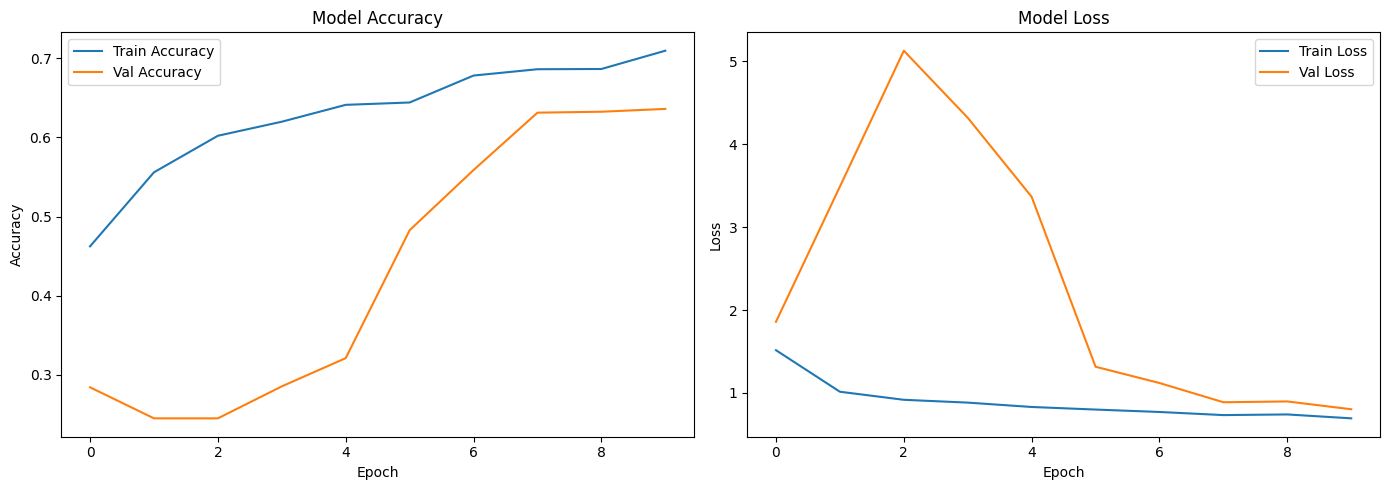

✅ Model saved as eye_disease_model.h5


In [7]:
# Task 11: Cross-Validation and Model Evaluation
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

model.save("eye_disease_model.h5")
print("✅ Model saved as eye_disease_model.h5")